### Example training

Only the first cell is relevant. The remaining cells are personal tests.

In [ ]:
import time
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import train
import train_lightning
import torchtrainer

params = {
    # Dataset
    'img_dir': Path('H:/datasets/segmentation/vessel/maximum_projection/images'),
    'label_dir': Path('H:/datasets/segmentation/vessel/maximum_projection/labels'),
    'crop_size': (256, 256),          
    'train_val_split': 0.1,
    'use_transforms': False,
    # Model
    'model_layers': (1, 1, 1, 1), 
    'model_channels': (4, 4, 4, 4), 
    # Training
    'epochs': 1,
    'lr': 0.001,
    'batch_size': 8,
    'momentum': 0.9,
    'weight_decay': 0.,
    'seed': 12,
    'loss': 'cross_entropy',
    'class_weights': (0.367, 0.633),
    # Efficiency
    'device': 'cuda',
    'num_workers': 3,
    'use_amp': False,
    'pin_memory': False,
    'non_blocking': False,
    # Other
    'resume': False,
    'log_dir': 'logs',
    'version':1,
    'save_best':True,
}

t0 = time.time()
#Train using pure Pytorch
logger, ds_train, ds_valid, model = train.run(params)
#Train using Pytorch Lightning
#ds_train, ds_valid, model, trainer = train_lightning.run(params)
print(time.time()-t0)

In [38]:
load_pl = False

if load_pl:
    import train_lightning
    model = train_lightning.LitSeg.load_from_checkpoint("logs/version_1/checkpoints/last.ckpt")
    model.to('cuda')
    model.eval()
else:
    checkpoint = torch.load(params['checkpoint_file'])
    model = torchtrainer.models.resnet_seg.ResNetSeg(params['model_layers'], params['model_channels'])
    model.to('cuda')
    model.load_state_dict(checkpoint["model"])
    model.eval();


In [42]:
from dataset import create_datasets
ds_train, ds_valid, _ = create_datasets(params['img_dir'], params['label_dir'], params['crop_size'], params['train_val_split'], use_simple=not params['use_transforms'])
ious = 0
for img, label in ds_valid:
    img = img.to('cuda')
    with torch.no_grad():
        output = model(img[None]).to('cpu')
        acc = torchtrainer.perf_funcs.segmentation_accuracy(output, label[None])
        ious += acc['iou']
print(ious/len(ds_valid))
# 0.71

tensor(0.7007)


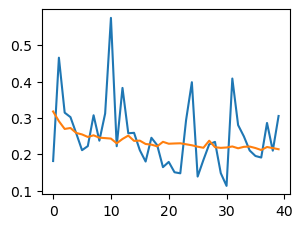

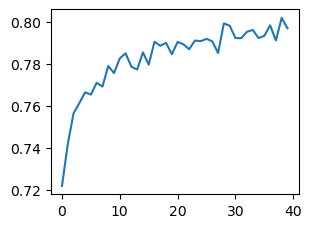

In [47]:
epochs, data = zip(*logger.data.items())
tl, vl, iou, _, _ = zip(*data)
plt.figure()
plt.plot(tl)
plt.plot(vl)
plt.figure()
plt.plot(iou)

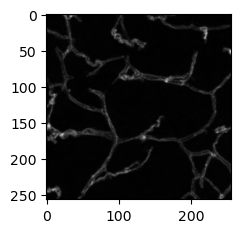

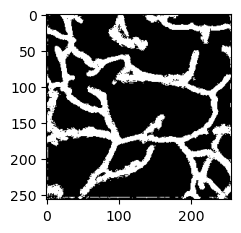

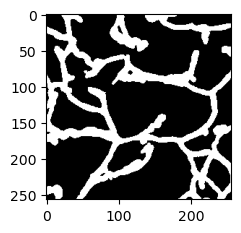

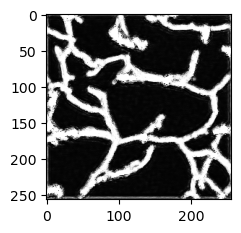

In [5]:
checkpoint = torch.load(params['checkpoint_file'])
model.to('cpu')
model.load_state_dict(checkpoint["model"])
model.eval()
img, label = ds_valid[0]
with torch.no_grad():
    res = model(img[None])[0]
    pred_label = res.argmax(dim=0)

plt.figure()
plt.imshow(img[0], 'gray')
plt.figure()
plt.imshow(pred_label, 'gray', vmin=0, vmax=1)
plt.figure()
plt.imshow(label, 'gray', vmin=0, vmax=1)
plt.figure()
plt.imshow(torch.nn.functional.softmax(res, dim=0)[1], 'gray', vmin=0, vmax=1)

In [36]:
import sys

sys.path.insert(0,'E:/Dropbox/deep_learning/torchtrainer')
import torchtrainer

model = torchtrainer.models.resnet_seg.ResNetSeg([1, 1, 1, 1, 1, 1, 1], [16, 64, 128, 256, 128, 64, 16])
torchtrainer.profiling.benchmark_model(model, (8, 1, 256, 256), no_grad=False, call_backward=True)

{'params': 0.0,
 'activations': 0.0,
 'flops': 0.0,
 'memory': 6.875845432281494,
 'time_cpu': 0.008002996444702148,
 'time_gpu': 0.6466478271484375,
 'info': ['params: M',
  'activations: G',
  'flops: G',
  'memory: GiB',
  'time_cpu: s',
  'time_gpu: s']}

### Tests

In [4]:
def gather_data(data, is_act=False):
    """Change data returned by the Inspector class from layer:stat to stat:layer."""

    data_l = []
    names = []
    for name, value in data.items():
        if is_act:
            data_l.append(value)
            names.append(name)           
        else:
            for param_name, param_value in value.items():
                data_l.append(param_value)
                names.append(name+'.'+param_name)

    mean, std, min, max = zip(*data_l)
    data_dict = {
        'mean':mean,
        'std':std,
        'min':min,
        'max':max,
        'names':names
    }

    return data_dict

def summarize_data(inspector):
    """Print the smallest and largest mean and standard deviation of each layer in the network. """

    params = inspector.get_params()
    grads = inspector.get_grads()
    acts = inspector.get_activations()
    param_dict = gather_data(params, is_act=False)
    grads_dict = gather_data(grads, is_act=False)
    acts_dict = gather_data(acts, is_act=True)
    data_dict = {'Param data':param_dict, 'Grad data':grads_dict, 'Activation data':acts_dict}
    print('Summary of data:')
    for data_type, data in data_dict.items():
        min_mean, max_mean = min(data['mean']), max(data['mean'])
        min_std, max_std = min(data['std']), max(data['std'])
        print(f'{data_type}: Smallest mean: {min_mean}, Largest mean: {max_mean}, Smallest std: {min_std}, Largest std: {max_std}')
        

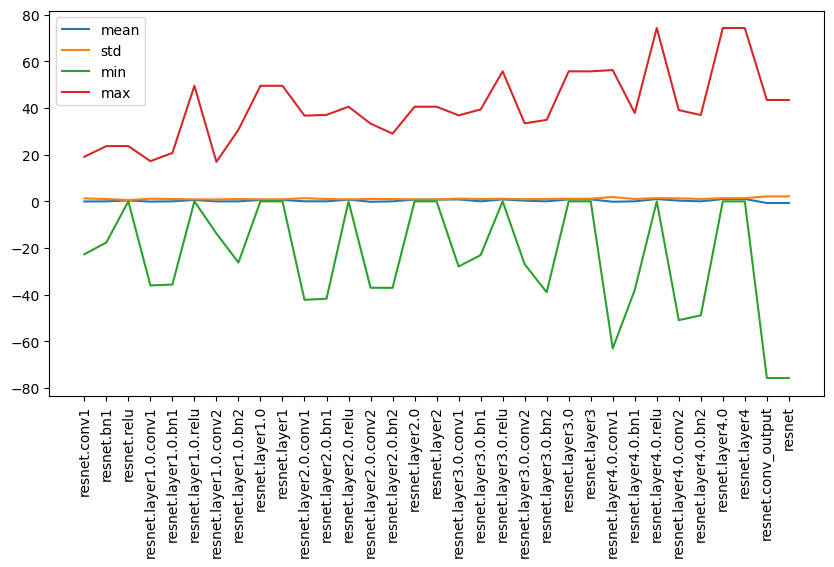

In [103]:
def plot_data(data, is_act=False):

    data_l = []
    names = []
    for name, value in data.items():
        if is_act:
            data_l.append(value)
            names.append(name)           
        else:
            for param_name, param_value in value.items():
                data_l.append(param_value)
                names.append(name+'.'+param_name)

    mean, std, min, max = zip(*data_l)

    plt.figure(figsize=(10, 5))
    plt.plot(names, mean, label='mean')
    plt.plot(names, std, label='std')
    plt.plot(names, min, label='min')
    plt.plot(names, max, label='max')
    plt.xticks(rotation=90)
    plt.legend()

insp = inspector.Inspector(model, agg_func=inspector.agg_func_stats)
insp.start_tracking_activations()
params = insp.get_params()
grads = insp.get_grads()
acts = insp.get_activations()
plot_data(acts, is_act=True)


In [ ]:
def create_histograms(data, is_act=False):

    min_val = torch.inf
    max_val = -torch.inf
    for name, value in data.items():
        if not is_act:
            value = value['weight']
        min = value.min()
        max = value.max()
        if min<min_val:
            min_val = min
        if max>max_val:
            max_val = max

    bins = torch.linspace(min_val, max_val, 100)
    hists = {}
    for name, value in data.items():
        if not is_act:
            value = value['weight']
        hist, _ = torch.histogram(value, bins)
        hists[name] = hist
        
    return hists, bins

def plot_histograms(hists, bins, figsize=(8, 20)):

    num_subplots = len(hists)
    plt.figure(figsize=figsize)
    for idx, (name, hist) in enumerate(hists.items()):
        plt.subplot(num_subplots, 1, idx+1)
        plt.plot(bins[:-1], hist)
        plt.title(name)
    plt.tight_layout()

params = insp.get_params()
grads = insp.get_grads()
acts = insp.get_activations()

hists, bins = create_histograms(params, True)
plot_histograms(hists, bins)